In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.signal as sig

from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [192]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [2]:
def logToMsgsValues(name):
    file = open(name)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('!'):
            arr = line[1:].strip().split(',')
            yield [(int(x) % 256) for x in arr[:-1]]
    if not found_christmas:
        print('ERROR! Did not find Christmas!')

def logToMsgsTypes(name):
    file = open(name)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith(':'):
            yield line[1:].strip().split(',')[:-1]
    if not found_christmas:
        print('ERROR! Did not find Christmas!')

def logToMsgsWeakness(name):
    file = open(name)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('?'):
            arr = line[1:].strip().split(',')
            yield [(int(x) % 256) for x in arr[:-1]]
    if not found_christmas:
        print('ERROR! Did not find Christmas!')


In [3]:
def selectBytes(msgs, numMsgs):
    return np.array([item for sublist in msgs[0:numMsgs] for item in sublist])

In [130]:
def loadBytes(base, N, generator=logToMsgsValues):
    all_bts = []
    max_len = 0
    for i in range(1,N+1):
        msgs = list(generator(base+'_'+str(i)+'.log'))
        bts = selectBytes(msgs, len(msgs))
        max_len = len(bts) if len(bts) > max_len else max_len
        all_bts.append(np.array(bts, dtype=float))
    for i in range(0,len(all_bts)):
        all_bts[i] = np.pad(all_bts[i], (0, max_len-len(all_bts[i])), 'constant', constant_values=np.nan)
    parts = np.vstack(all_bts)
    return parts

In [131]:
def loadTypes(base, N):
    all_msgs = []
    for i in range(1,N+1):
        msgs = list(logToMsgsTypes(base+'_'+str(i)+'.log'))
        all_msgs.append([item for sublist in msgs for item in sublist]) # Flatten
    # Make map of all types
    all_types = []
    max_len = 0
    for msgs in all_msgs:
        max_len = len(msgs) if len(msgs) > max_len else max_len
        for msg in msgs:
            if not (msg in all_types):
                all_types.append(msg)
    all_types.sort()
    # Map all values to type index
    all_arrs = []
    for msgs in all_msgs:
        arr = np.array([all_types.index(msg) for msg in msgs])
        # Pad to maxlen
        all_arrs.append(np.pad(arr, (0, max_len-len(arr)), 'constant', constant_values=-1))
        
    return all_types, np.vstack(all_arrs)

In [171]:
base_dir = '../resources/logs/nodejs_test_3/'
N = 100

base_data = loadBytes(base_dir+'base',N)
static_data = loadBytes(base_dir+'static',N)
runtime_data = loadBytes(base_dir+'runtime',N)

In [172]:
### Accross instances
def instDiffs(data):
    num_instances = data.shape[0]
    num_bytes = data.shape[1]
    
    diffs = np.zeros((num_instances,))
    
    for i in range(0,num_instances):
        own_bytes = data[i,:].copy()
        own_bytes[np.isnan(own_bytes)] = 0
        diff = 0
        for j in range(0,num_instances):
            if i != j:
                other_bytes = data[j,:].copy()
                other_bytes[np.isnan(other_bytes)] = 0
                diff += np.sum(np.abs(own_bytes-other_bytes))/num_bytes
        diffs[i] = diff/(num_instances-1)
                
    return diffs


In [173]:
### Accross time
def timeDiffs(data):
    N = 100
    num_instances = data.shape[0]
    
    diffs = np.zeros((N,N))
    
    for i in range(0, num_instances):
        inst_bytes = data[i,:]
        inst_bytes = inst_bytes[np.logical_not(np.isnan(inst_bytes))]
        interaction_length = int(inst_bytes.size/N)
        
        for j in range(0,N):
            for k in range(0,N):
                first = inst_bytes[j*interaction_length:(j+1)*interaction_length]
                second = inst_bytes[k*interaction_length:(k+1)*interaction_length]
                diffs[j,k] += np.sum(np.abs(first-second))/interaction_length
                
    return np.sum(diffs, axis=1)/((N-1)*num_instances)

In [214]:
def plotValueAndMean(data, color, alpha=0.3):
    plt.plot(data, color=color, alpha=alpha)
    mean = np.mean(data)
    line, = plt.plot([0, data.size-1], [mean, mean], color=color)
    return line

In [176]:
base_inst_diff = instDiffs(base_data)
stat_inst_diff = instDiffs(static_data)
runt_inst_diff = instDiffs(runtime_data)

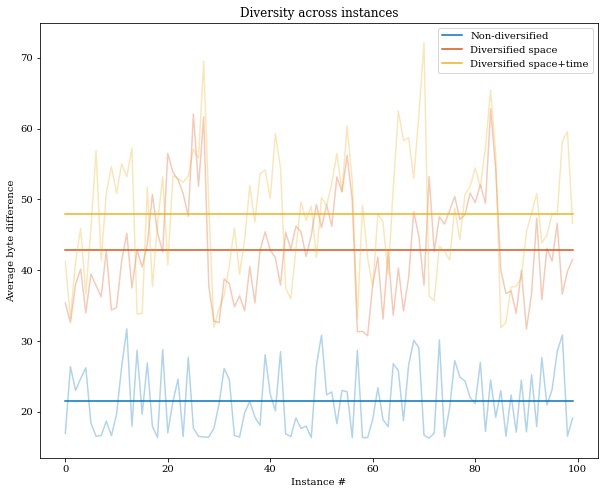

In [228]:
plt.figure(1, figsize=(10,8))

baseL = plotValueAndMean(base_inst_diff, colors[0])
statL = plotValueAndMean(stat_inst_diff, colors[1])
runtL = plotValueAndMean(runt_inst_diff, colors[2])

plt.legend((baseL, statL, runtL), ('Non-diversified','Diversified space','Diversified space+time'), loc='upper right')

plt.xlabel('Instance #')
plt.ylabel('Average byte difference')
plt.title('Diversity across instances')

plt;

In [177]:
base_time_diff = timeDiffs(base_data)
stat_time_diff = timeDiffs(static_data)
runt_time_diff = timeDiffs(runtime_data)

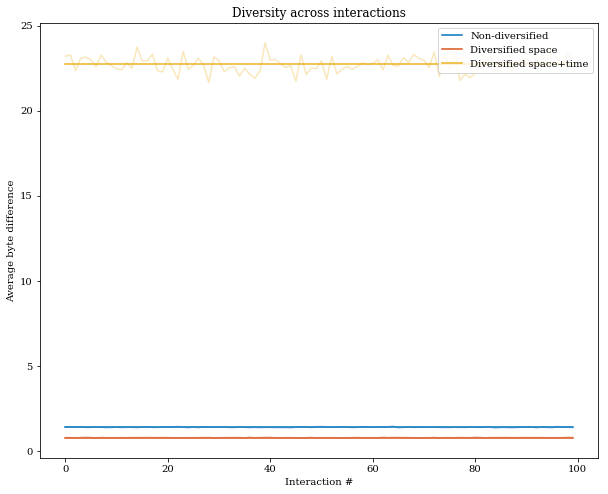

In [230]:
plt.figure(2, figsize=(10,8))

baseL = plotValueAndMean(base_time_diff, colors[0])
statL = plotValueAndMean(stat_time_diff, colors[1])
runtL = plotValueAndMean(runt_time_diff, colors[2])

plt.legend((baseL, statL, runtL), ('Non-diversified','Diversified space','Diversified space+time'), loc='upper right')

plt.xlabel('Interaction #')
plt.ylabel('Average byte difference')
plt.title('Diversity across interactions')

plt;